multiple regression analysis. In this type of model, we attempt to model the relationship between multiple explanatory variables to a single dependent variable. While adding more variables allows us to model more complex phenomenons there are also additional steps we must take to make sure our model is sound and robust.

### import our Libraries

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

### Load the data

In [14]:
#load the data in to pandas

econ_df = pd.read_excel('korea_data.xlsx')
econ_df = econ_df.replace("..","nan")

#set index equal to the year column
econ_df.index = econ_df['Year']
econ_df = econ_df.drop('Year', axis=1)

#set the data type of the data frame
econ_df = econ_df.astype(float)

#set work with the data from 1969 to 2016, ignore year 2017
econ_df = econ_df.loc['1969':'2016']

column_names = {'Unemployment, total (% of total labor force) (national estimate)':'unemployment',
                'GDP growth (annual %)': 'gdp_growth',
                'Gross capital formation (% of GDP)':'gross_capital_formation',
                'Population growth (annual %)':'pop_growth', 
                'Birth rate, crude (per 1,000 people)':'birth_rate',
                'Broad money growth (annual %)':'broad_money_growth',                
                'Final consumption expenditure (% of GDP)':'final_consum_gdp',
                'Final consumption expenditure (annual % growth)':'final_consum_growth',
                'General government final consumption expenditure (annual % growth)':'gov_final_consum_growth',
                'Gross capital formation (annual % growth)':'gross_cap_form_growth',
                'Households and NPISHs Final consumption expenditure (annual % growth)':'hh_consum_growth'}
#rename the column names
econ_df = econ_df.rename(columns=column_names)

#check for nulls
display(econ_df.isnull().any())
econ_df.head()

gdp_growth                 False
gross_capital_formation    False
pop_growth                 False
birth_rate                 False
broad_money_growth         False
final_consum_growth        False
gov_final_consum_growth    False
gross_cap_form_growth      False
hh_consum_growth           False
unemployment               False
dtype: bool

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
Year,,,,,,,,,,
1969,14.541235,29.943577,2.263434,30.663,60.984733,10.693249,10.640799,29.908118,10.700325,4.86
1970,9.997407,26.338200,2.184174,31.200,27.422864,10.161539,7.279573,0.058667,10.557300,4.51
1971,10.454693,25.558501,1.971324,31.200,20.844481,9.330434,8.610547,15.172870,9.426969,4.57
1972,7.150715,21.404761,1.875999,28.400,33.815028,5.788458,8.134824,-13.056701,5.471355,4.59
1973,14.827554,25.872858,1.768293,28.300,36.415629,8.089952,2.287729,32.098276,8.927295,4.04


##  Check for Perfect Multicollinearity


##### How to test for multicollinearity

<AxesSubplot: >

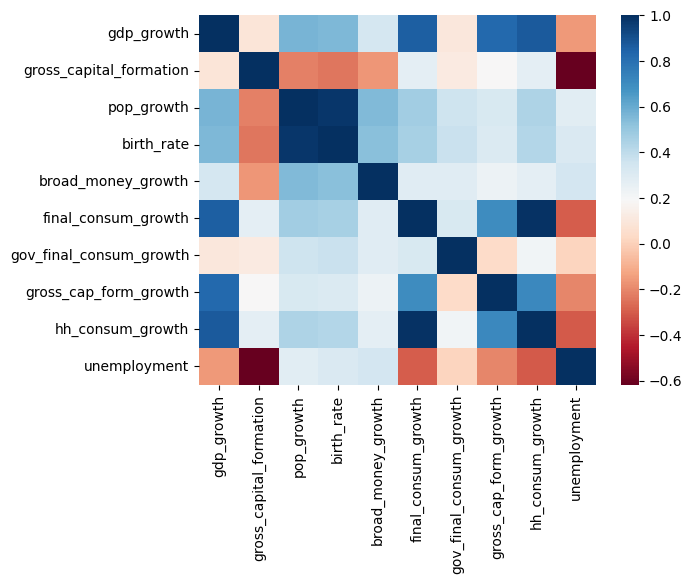

In [15]:
#print our a correlation matrix of our data frame
corr = econ_df.corr()
# plot a heatmap
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, cmap = 'RdBu')

However, we should be more systematic in our approach to removing highly correlated variables. One method we can use is the variance_inflation_factor which is a measure of how much a particular variable is contributing to the standard error in the regression model. When significant multicollinearity exists, the variance inflation factor will be huge for the variables in the calculation.

A general recommendation is that if any of our variables come back with a value of 5 or higher, then they should be removed from the model

variance_inflation_factor

In [16]:
econ_df_before = econ_df
econ_df_after = econ_df.drop(['birth_rate', 'final_consum_growth','gross_capital_formation'], axis = 1)

X1 = sm.tools.add_constant(econ_df_before)
X2 = sm.tools.add_constant(econ_df_after)

#create a series
series_before = pd.Series([variance_inflation_factor(X1.values,i) for i in range(X1.shape[1])], index = X1.columns)
series_after = pd.Series([variance_inflation_factor(X2.values,i) for i in range(X2.shape[1])], index = X2.columns)

#display the data
print('DATA BEFORE')
print('-'*100)
display(series_before)

print('DATA AFTER')
print('-'*100)
display(series_after)

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                       314.550195
gdp_growth                    9.807879
gross_capital_formation       2.430057
pop_growth                   25.759263
birth_rate                   26.174368
broad_money_growth            1.633079
final_consum_growth        2305.724583
gov_final_consum_growth      32.527332
gross_cap_form_growth         3.796420
hh_consum_growth           2129.093634
unemployment                  2.800008
dtype: float64

DATA AFTER
----------------------------------------------------------------------------------------------------


const                      29.930686
gdp_growth                  9.366468
pop_growth                  2.636300
broad_money_growth          1.604662
gov_final_consum_growth     1.361763
gross_cap_form_growth       3.553567
hh_consum_growth            5.114816
unemployment                1.588427
dtype: float64

nother way to visualize our data to check for multicollinearity. Inside of pandas, there is a scatter_matrix chart that will create a scatter plot for each variable in our dataset against another variable. This is a great tool for visualizing the correlation of one variable across all the other variables in the dataset. I'll take my econ_df_after and pass it through the scatter_matrix method

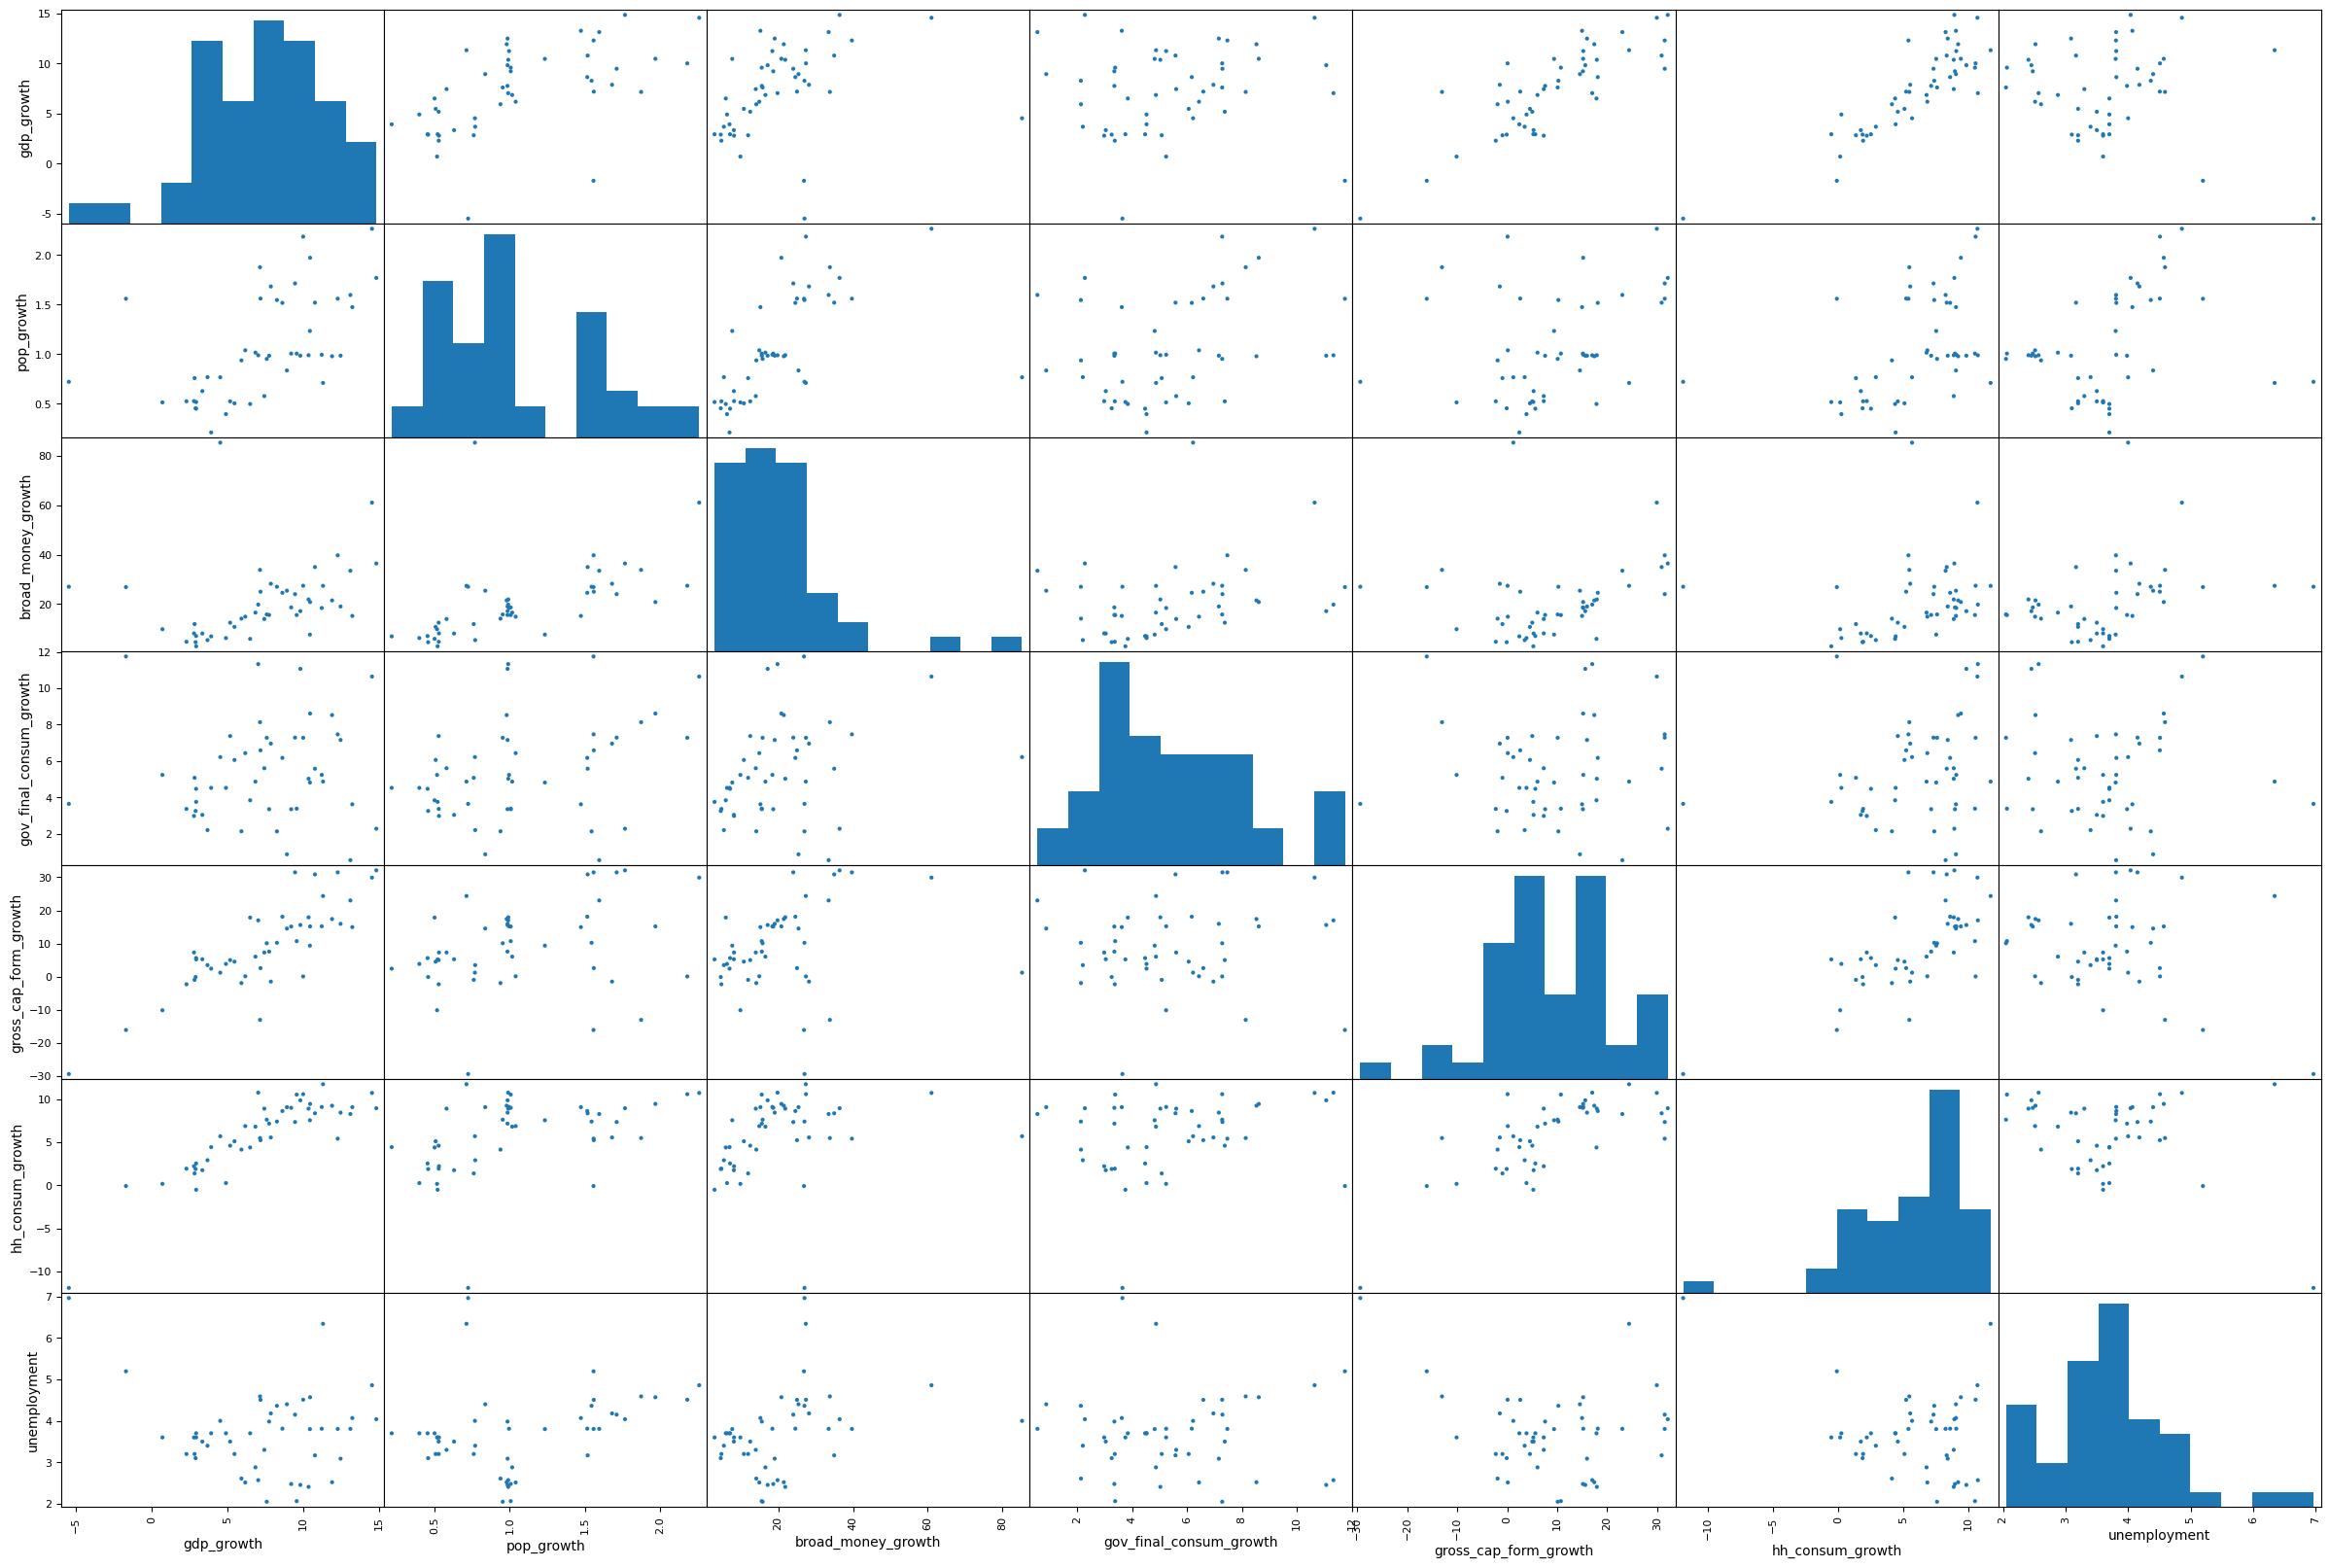

In [17]:
#DEFINE the plot
pd.plotting.scatter_matrix(econ_df_after, alpha = 1, figsize = (30,20))

#show the plot
plt.show()

## Describe the Dataset 

In [18]:
desc_df = econ_df.describe()


#add the standard deviation metrics
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

desc_df

,gdp_growth,gross_capital_formation,pop_growth,birth_rate,broad_money_growth,final_consum_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.280315,32.433236,1.058072,16.340896,20.426621,5.820239,5.419214,8.965681,5.879176,3.678096
std,4.209306,4.136932,0.514039,6.814683,14.748442,3.627444,2.622254,12.629912,4.227720,0.968616
min,-5.471219,21.404761,0.211998,7.900000,2.980690,-9.288825,0.560957,-29.403255,-11.894309,2.048000
25%,4.374899,29.776910,0.615602,9.950000,10.586461,3.591334,3.384407,2.114078,3.825773,3.150475
50%,7.513471,32.335229,0.985132,15.150000,17.807598,6.531163,5.056509,7.431966,6.999971,3.700000
75%,10.376191,34.474874,1.525765,21.750000,26.923837,8.179037,7.188470,16.210283,8.938837,4.088500
max,14.827554,41.374062,2.263434,31.200000,85.203081,10.834413,11.742807,32.098276,11.711835,6.963000
+3_std,19.908232,44.844034,2.600188,36.784945,64.671947,16.702571,13.285976,46.855416,18.562336,6.583944
-3_std,-5.347602,20.022439,-0.484044,-4.103153,-23.818705,-5.062092,-2.447547,-28.924054,-6.803985,0.772247


# filtering the Dataset

In [19]:
#filter the outliers
econ_remove_df = econ_df[(np.abs(stats.zscore(econ_df))< 3).all(axis=1)]

#what rows were removed
econ_df.index.difference(econ_remove_df.index)

Int64Index([1998, 2001], dtype='int64', name='Year')

# Build the Model

In [20]:
econ_df_after.head()

,gdp_growth,pop_growth,broad_money_growth,gov_final_consum_growth,gross_cap_form_growth,hh_consum_growth,unemployment
Year,,,,,,,
1969,14.541235,2.263434,60.984733,10.640799,29.908118,10.700325,4.86
1970,9.997407,2.184174,27.422864,7.279573,0.058667,10.557300,4.51
1971,10.454693,1.971324,20.844481,8.610547,15.172870,9.426969,4.57
1972,7.150715,1.875999,33.815028,8.134824,-13.056701,5.471355,4.59
1973,14.827554,1.768293,36.415629,2.287729,32.098276,8.927295,4.04


In [21]:
#define our input variable and output variable
X = econ_df_after.drop('gdp_growth', axis=1)
Y = econ_df_after[['gdp_growth']]

#split dataset into training and testing portion
x_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

#create an instance of our model
regression_model = LinearRegression()

#fit the model
regression_model.fit(x_train, y_train)

LinearRegression()

## Exploring the Output

In [22]:
#grab the intercept and the coef
intercept = regression_model.intercept_[0]
coef = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

The intercept for our model is 2.08
----------------------------------------------------------------------------------------------------
The Coefficient for pop_growth is 2.0
The Coefficient for broad_money_growth is -0.0017
The Coefficient for gov_final_consum_growth is -0.21
The Coefficient for gross_cap_form_growth is 0.14
The Coefficient for hh_consum_growth is 0.51
The Coefficient for unemployment is 0.027


### make predictions with our newly trained model
#### Get multiple predictions

In [23]:
## Get multiple predictions
y_predict = regression_model.predict(X_test)

#show the first 5 predictions
y_predict[:5]

array([[ 7.61317534],
       [ 6.31344066],
       [ 5.06818662],
       [ 4.19869856],
       [11.11885324]])

## Evaluating the Model

## Using the Statsmodel

In [ ]:
#define our input
X2 = sm.add_constant(X)

#create an OLS model
model = sm.OLS(Y,X2)

#fit the data
est = model.fit()

## Checking for Heteroscedasticity